In [3]:
import h5py
# import openslide
import torch
import pandas as pd
from prototype_visualization_utils import get_panther_encoder, visualize_categorical_heatmap, get_mixture_plot, get_default_cmap

import sys
sys.path.append('../')
from mil_models.tokenizer import PrototypeTokenizer

In [21]:
### Loading PANTHER Encoder
proto_path = r'C:\Users\Vivian\Documents\PANTHER\PANTHER\src\splits\FA_PT_k=0\prototypes\prototypes_c16_uni_kmeans_num_1.0e+06.pkl' # 5x uni
# proto_path = r'C:\Users\Vivian\Documents\PANTHER\PANTHER\src\splits\FA_PT_10x_k=0\prototypes\prototypes_c16_uniextracted_mag10x_patch224_fp_kmeans_num_1.0e+06.pkl' # 10x uni
# proto_path = r'C:\Users\Vivian\Documents\PANTHER\PANTHER\src\splits\FA_PT_2.5x_k=0\prototypes\prototypes_c16_uniextracted_mag2.5x_patch224_fp_kmeans_num_1.0e+06.pkl' # 2.5x uni
# , model_config='PANTHER_fa_pt' out_type='allcat', 
panther_encoder = get_panther_encoder(in_dim=1024, p=16, proto_path=proto_path, config_dir=r'C:\Users\Vivian\Documents\PANTHER\PANTHER\src\configs', model_config='PANTHER_fa_pt', out_type='allcat')

📌 Loaded config path: C:\Users\Vivian\Documents\PANTHER\PANTHER\src\configs\PANTHER_fa_pt\config.json
📌 Loaded config_dict from JSON: {'in_dim': 1024, 'n_classes': 2, 'heads': 1, 'em_iter': 1, 'tau': 0.001, 'ot_eps': 0.1, 'n_fc_layers': 0, 'dropout': 0.25, 'out_type': 'allcat', 'out_size': 8, 'load_proto': False, 'proto_path': '.', 'fix_proto': False}


qq dtype: float32
qq shape: (1195, 16)
qq type: <class 'numpy.ndarray'>
qq contains NaNs or infs? False
UMAP(random_state=42)
UMAP shape: (1195, 2)


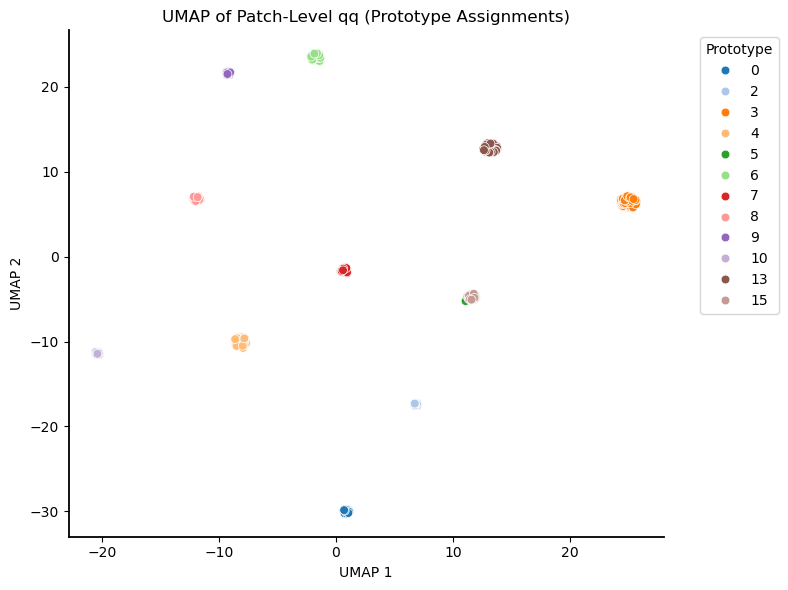

In [ ]:
import h5py
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# Load patch features
with h5py.File(r'C:\Users\Vivian\Documents\PANTHER\PANTHER\features\uniextracted_mag5x_patch224_fp\feats_h5\PT 41 B.h5', 'r') as h5:
    feats = torch.Tensor(h5['features'][:])  # shape: [N, D]

#  ----------------
# # Get qq values from encoder (soft prototype assignments)
# with torch.inference_mode():
#     info = panther_encoder.representation(feats.unsqueeze(0))
#     qq = info['qq'][0, :, :, 0].cpu().numpy()  # shape: (N_patches, n_prototypes)
#     labels = qq.argmax(axis=1)  # most dominant prototype per patch

# # Apply t-SNE (you can also try UMAP)
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# qq_tsne = tsne.fit_transform(qq)

# -----------------------

# Use UMAP instead of t-SNE
# Get qq values from encoder (soft prototype assignments)
with torch.inference_mode():
    info = panther_encoder.representation(feats.unsqueeze(0))
    qq = info['qq'][0, :, :, 0].cpu().numpy()  # shape: (N_patches, n_prototypes)
    qq = np.asarray(qq, dtype=np.float32)  # ✅ ensure proper dtype
    labels = qq.argmax(axis=1)

# Run UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
print(reducer)
qq_tsne = reducer.fit_transform(qq)
print("UMAP shape:", qq_tsne.shape)
#  -----------------------

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=qq_tsne[:, 0], y=qq_tsne[:, 1], hue=labels, palette='tab20', s=40)
# plt.title("t-SNE of Patch-Level qq (Prototype Assignments)")
# plt.xlabel("TSNE-1")
# plt.ylabel("TSNE-2")

plt.title("UMAP of Patch-Level qq (Prototype Assignments)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

plt.legend(title="Prototype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


mapping clusters to classes

In [ ]:
import os
import numpy as np
import torch
import h5py
import pandas as pd
import matplotlib.pyplot as plt

# ----------- Configuration -----------
# h5_dir = r'C:\Users\Vivian\Documents\PANTHER\PANTHER\features\unifiltextracted_mag5x_patch224_fp\feats_h5' # 5x filt
h5_dir = r'C:\Users\Vivian\Documents\CLAM\CLAM\FEATURES_DIR_5x\FEATURES_DIR_2.5x\uniextracted_mag2x_patch224_fp\feats_h5' # 2.5x uni
csv_paths = {
    'Train': r'C:\Users\Vivian\Documents\PANTHER\PANTHER\src\splits\FA_PT_2.5x_k=0\train.csv',
    'Val':   r'C:\Users\Vivian\Documents\PANTHER\PANTHER\src\splits\FA_PT_2.5x_k=0\val.csv',
    'Test':  r'C:\Users\Vivian\Documents\PANTHER\PANTHER\src\splits\FA_PT_2.5x_k=0\test.csv'
}
label_map = {'FA': 0, 'PT': 1}
n_prototypes = 16
# save_fig_dir = r'C:\Users\Vivian\Documents\PANTHER\PANTHER\src\cluster_proto_maps'  # optional

# os.makedirs(save_fig_dir, exist_ok=True)

# ----------- Loop over splits -----------
for split_name, csv_path in csv_paths.items():
    print(f"\n📊 Processing {split_name} split...")

    df = pd.read_csv(csv_path)
    prototype_importance_per_class = {0: [], 1: []}

    for _, row in df.iterrows():
        slide_id = row['slide_id']
        label_str = row['label']
        label = label_map.get(label_str)
        h5_path = os.path.join(h5_dir, f"{slide_id}.h5")

        if not os.path.exists(h5_path):
            print(f"❌ Missing: {slide_id}.h5")
            continue

        with h5py.File(h5_path, 'r') as f:
            feats = torch.Tensor(f['features'][:])

        with torch.inference_mode():
            info = panther_encoder.representation(feats.unsqueeze(dim=0))
            qqs = info['qq'][0, :, :, 0].cpu().numpy()  # shape: (N, n_prototypes)

        proto_sum = np.sum(qqs, axis=0)
        if np.sum(proto_sum) == 0:
            print(f"⚠️ No prototype activation for: {slide_id}")
            continue

        proto_contrib = proto_sum / np.sum(proto_sum)
        prototype_importance_per_class[label].append(proto_contrib)

        print(f"✅ Processed: {slide_id} | Label: {label_str}")

    # ----------- Compute and Plot -----------
    fa_mean = np.mean(prototype_importance_per_class[0], axis=0)
    pt_mean = np.mean(prototype_importance_per_class[1], axis=0)
    heatmap_data = np.stack([fa_mean, pt_mean], axis=0)  # (2, n_prototypes)

    plt.figure(figsize=(10, 4))
    plt.imshow(heatmap_data.T, cmap='viridis', aspect='auto')
    plt.colorbar(label='Avg Importance')
    plt.xticks([0, 1], ['FA', 'PT'])
    plt.yticks(range(n_prototypes), [f'Proto {i}' for i in range(n_prototypes)])
    plt.xlabel('Class')
    plt.ylabel('Prototype')
    plt.title(f'Prototype Importance - {split_name} Set')
    plt.tight_layout()

    # Save figure
    # save_path = os.path.join(save_fig_dir, f'proto_importance_{split_name.lower()}.png')
    # plt.savefig(save_path)
    # print(f"📁 Saved heatmap to: {save_path}")
    plt.show()


visualizing without loading wsi

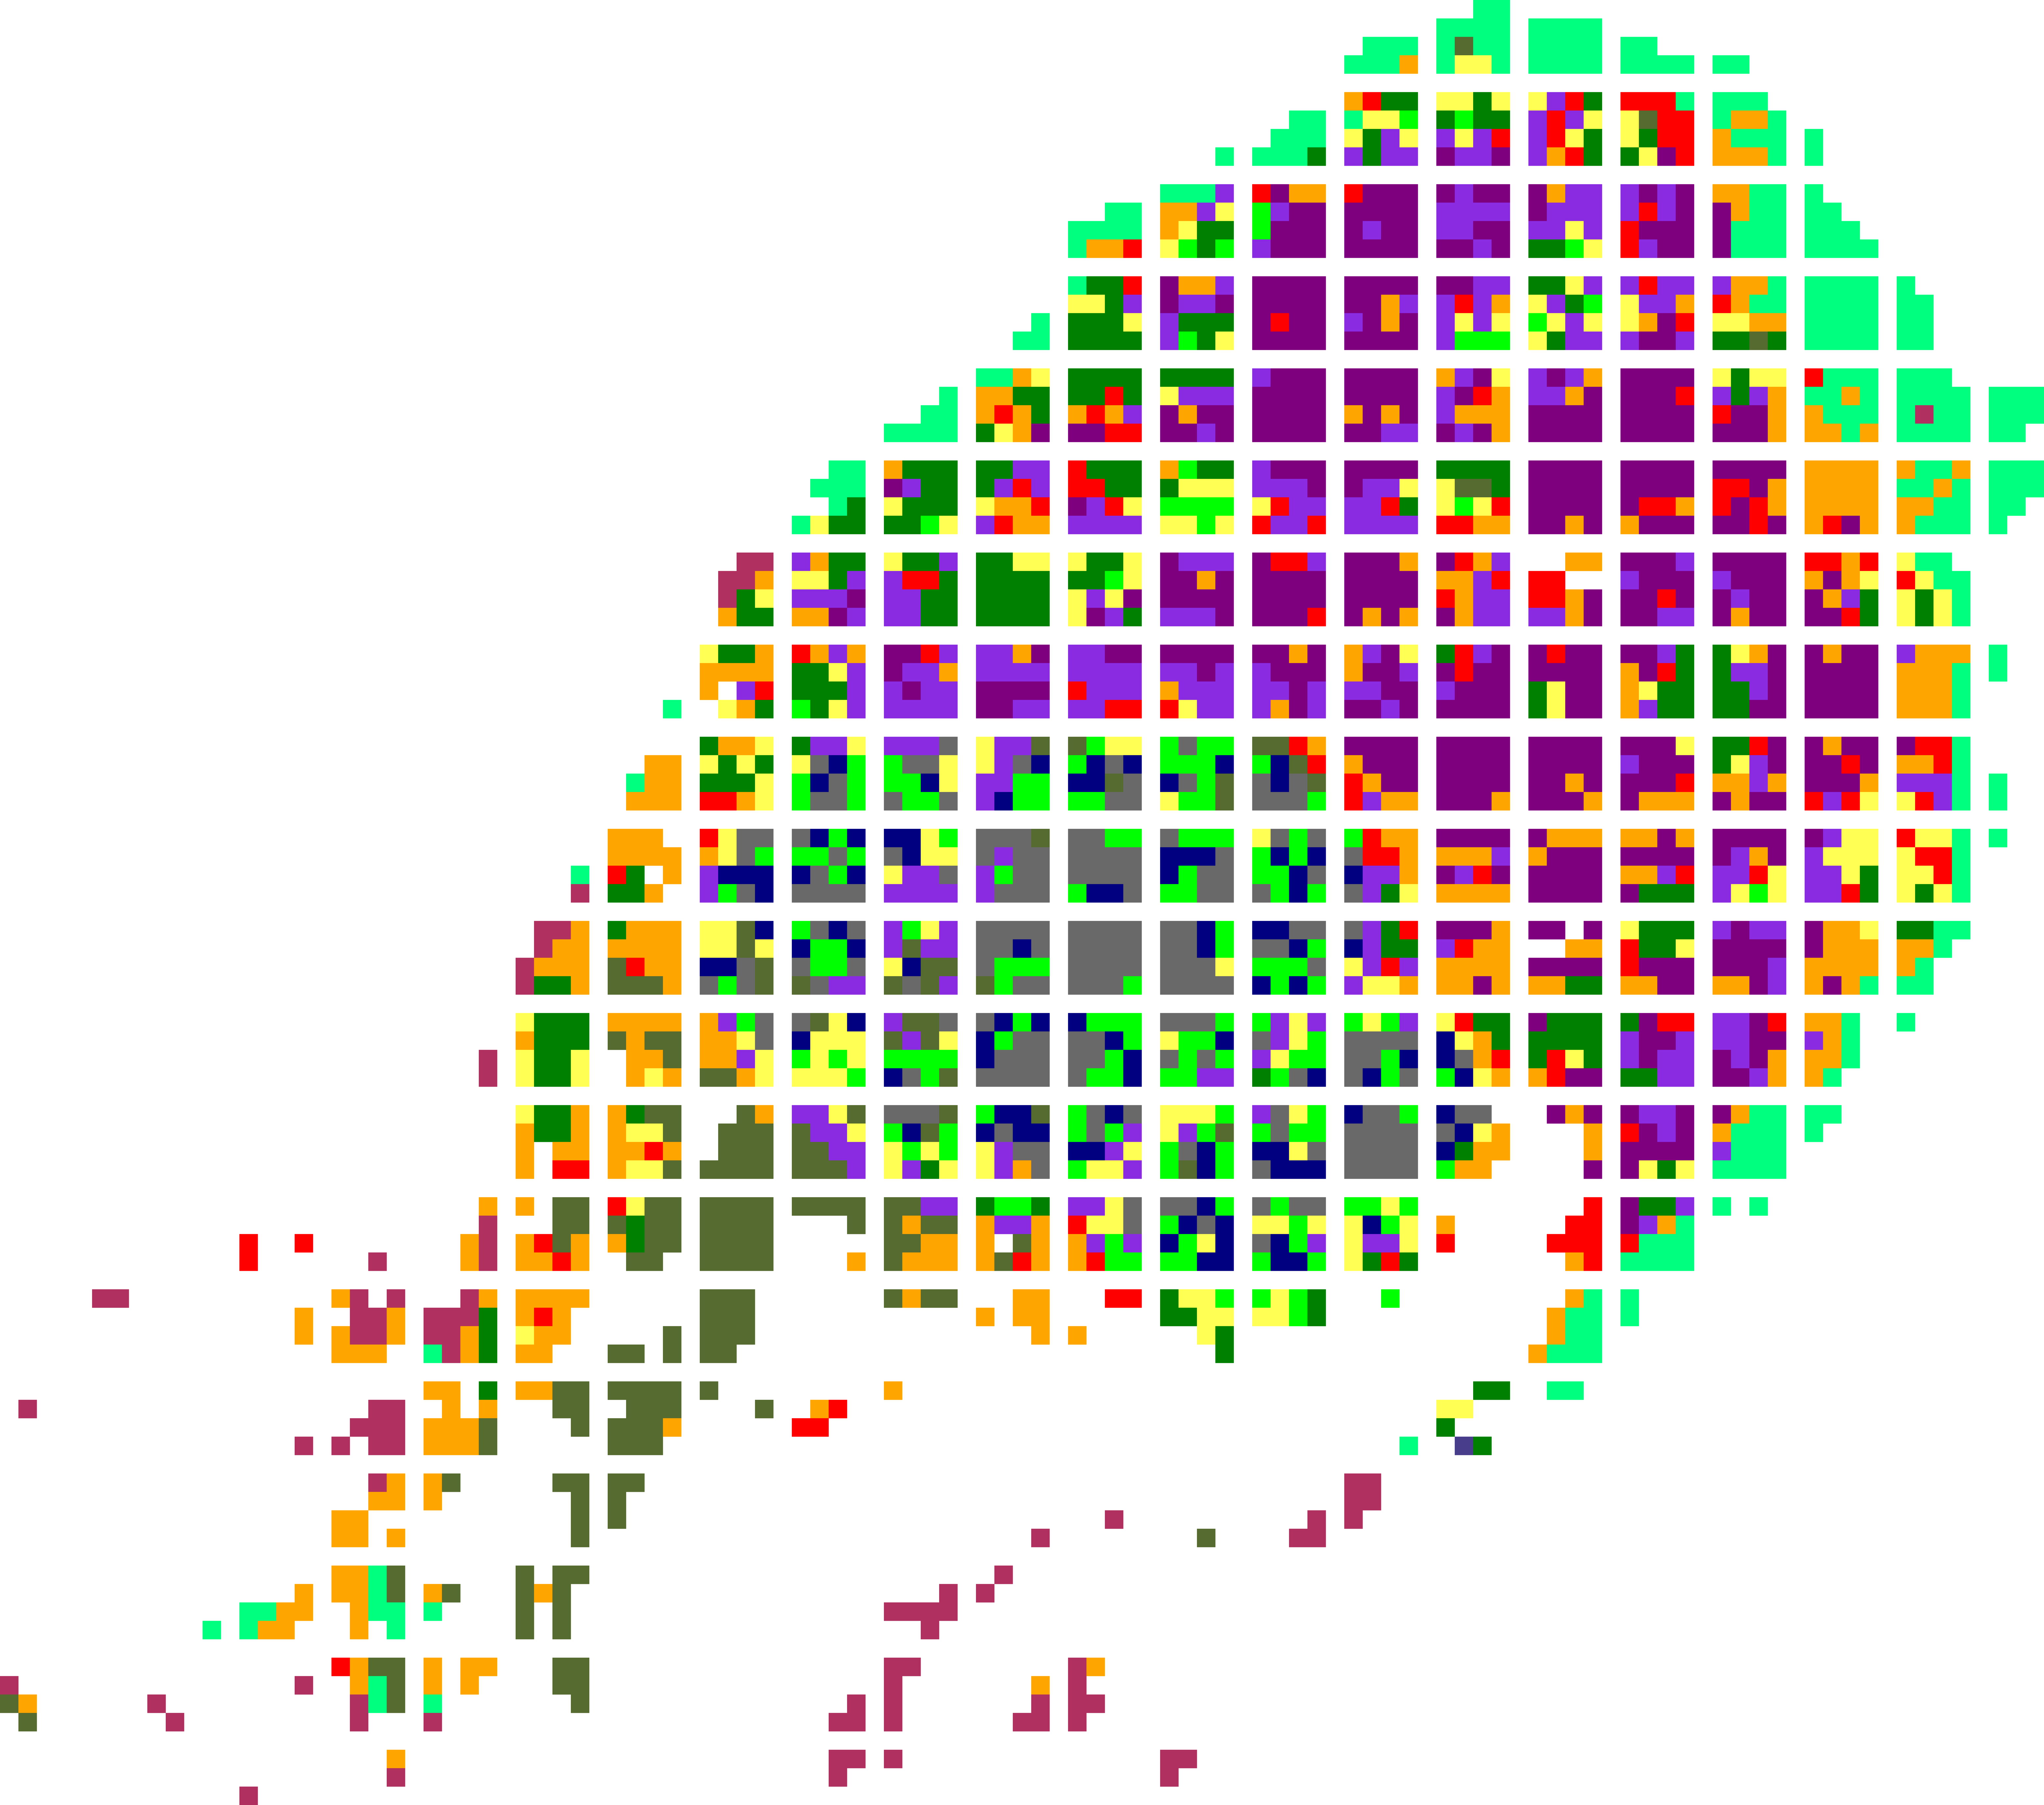

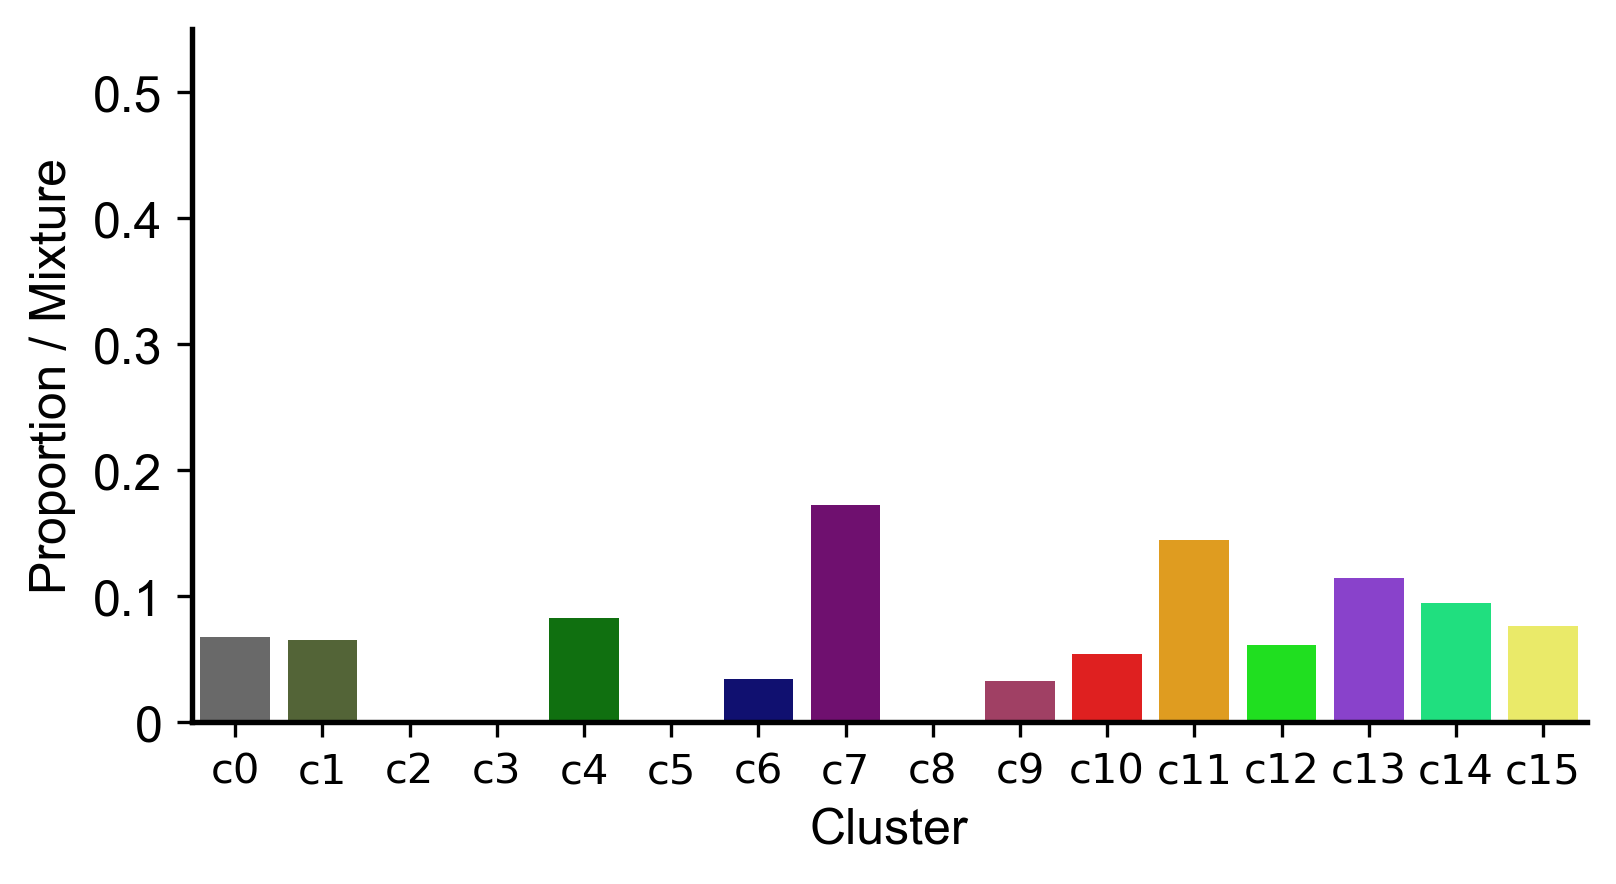

In [8]:
import h5py
import numpy as np
from PIL import Image, ImageDraw
from prototype_visualization_utils import get_default_cmap


h5_feats_fpath = r'C:\Users\Vivian\Documents\CLAM\CLAM\FEATURES_DIR_5x\FEATURES_DIR_10x\uniextracted_mag10x_patch224_fp\feats_h5\PT 41 B.h5'

h5 = h5py.File(h5_feats_fpath, 'r')

coords = h5['coords'][:]
feats = torch.Tensor(h5['features'][:])
# patch_size = h5['coords'].attrs['patch_size']
patch_size = 224

### get PANTHER representation and GMM mixtures
with torch.inference_mode():
    info = panther_encoder.representation(feats.unsqueeze(dim=0))
    # print(info.keys()) # debugging
    qqs = info['qq']
    out = info['repr']
    # print("qqs.shape:", qqs.shape)  # Debugging
    # print("out.shape:", out.shape)  # Debugging
    # print("qqs:", qqs[:10]) # debugging
    tokenizer = PrototypeTokenizer(out_type='allcat', p=16)
    mus, pis, sigmas = tokenizer.forward(out)
    # print("mus.shape:", mus.shape)  # Debugging
    # print("qqs.shape:", qqs.shape)  # Debugging
    # print('sigmas.shape:', sigmas.shape)  # Debugging

    mus = mus[0].detach().cpu().numpy()
    qq = qqs[0,:,:,0].cpu().numpy()
    global_cluster_labels = qq.argmax(axis=1)

# Get bounding box of full patch region
x_min, y_min = coords.min(axis=0)
coords -= np.array([x_min, y_min])  # Normalize to (0,0)
max_x, max_y = coords.max(axis=0) + patch_size
canvas_w, canvas_h = int(max_x), int(max_y)

# Create blank white canvas
canvas = Image.new('RGBA', (canvas_w, canvas_h), (255, 255, 255, 255))
draw = ImageDraw.Draw(canvas, 'RGBA')

# cmap = get_default_cmap(len(np.unique(global_cluster_labels)))
cmap = get_default_cmap(int(global_cluster_labels.max()) + 1)

alpha = 1
scale = 0.25  # Adjust as needed

# Draw rectangles
for (x, y), label in zip(coords, global_cluster_labels):
    color = cmap[label]
    rgba = color + (int(255 * alpha),)  # Add alpha
    draw.rectangle([x, y, x + patch_size, y + patch_size], fill=rgba)

# Resize for visualization
if scale < 1.0:
    canvas = canvas.resize((int(canvas_w * scale), int(canvas_h * scale)))
display(canvas)
display(get_mixture_plot(mus))

visualize patches per cluster

In [4]:
from collections import defaultdict
import random

cluster_to_coords = defaultdict(list)
for coord, label in zip(coords, global_cluster_labels):
    cluster_to_coords[label].append(coord)


with randomized selection of patches

In [9]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from prototype_visualization_utils import get_default_cmap
from mil_models.tokenizer import PrototypeTokenizer
import glob
import random

def visualize_cluster_patches_for_slide(
    h5_feats_fpath,
    patch_dir,
    panther_encoder,
    patch_size=224,
    max_patches_per_cluster=4,
    random_seed=None,
    save_path=None
):
    """
    Visualizes a few random patch examples from each prototype cluster for a single slide.

    Parameters:
    - h5_feats_fpath (str): path to the .h5 file with 'features' and 'coords'.
    - patch_dir (str): path to the directory containing .npy patches for the slide.
    - panther_encoder (torch.nn.Module): trained encoder that returns representation and qq.
    - patch_size (int): size of each square patch.
    - max_patches_per_cluster (int): number of patches to show per cluster.
    - random_seed (int or None): seed for reproducibility.
    - save_path (str or None): path to save the final image (optional).
    """
    if random_seed is not None:
        random.seed(random_seed)

    with h5py.File(h5_feats_fpath, 'r') as h5:
        coords = h5['coords'][:]
        feats = torch.Tensor(h5['features'][:])

    with torch.inference_mode():
        info = panther_encoder.representation(feats.unsqueeze(dim=0))
        qqs = info['qq']
        out = info['repr']
        tokenizer = PrototypeTokenizer(out_type='allcat', p=qqs.shape[2])
        tokenizer.forward(out)  # Optional
        qq = qqs[0, :, :, 0].cpu().numpy()
        global_cluster_labels = qq.argmax(axis=1)

    original_coords = coords.copy()
    samples_per_cluster = {}
    for label, (x, y) in zip(global_cluster_labels, original_coords):
        samples_per_cluster.setdefault(label, []).append((int(x), int(y)))

    n_clusters = len(samples_per_cluster)
    fig, axs = plt.subplots(n_clusters, max_patches_per_cluster, figsize=(max_patches_per_cluster * 3, n_clusters * 3))
    if n_clusters == 1:
        axs = np.expand_dims(axs, axis=0)

    # for row_idx, (cluster_id, coords_list) in enumerate(samples_per_cluster.items()):
    for row_idx, cluster_id in enumerate(sorted(samples_per_cluster.keys())):
        coords_list = samples_per_cluster[cluster_id]

        selected_coords = random.sample(coords_list, k=min(max_patches_per_cluster, len(coords_list)))
        for col_idx in range(max_patches_per_cluster):
        # for col_idx in range(max_patches_per_cluster): # not randomized
            ax = axs[row_idx][col_idx]
            if col_idx >= len(selected_coords):
                ax.axis('off')
                continue

            x, y = selected_coords[col_idx]
            pattern = f'*_x{x}_y{y}.npy'
            matches = glob.glob(os.path.join(patch_dir, pattern))

            if not matches:
                print(f"⚠️ Missing patch ending with _x{x}_y{y}.npy")
                ax.axis('off')
                continue

            patch = np.load(matches[0])
            ax.imshow(patch.astype(np.uint8))
            ax.set_title(f'Cluster {cluster_id}' if col_idx == 0 else "")
            ax.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


In [ ]:
visualize_cluster_patches_for_slide(
    h5_feats_fpath=r'C:\Users\Vivian\Documents\CLAM\CLAM\FEATURES_DIR_5x\FEATURES_DIR_10x\uniextracted_mag10x_patch224_fp\feats_h5\PT 41 B.h5',
    patch_dir=r'C:\Users\Vivian\Documents\CONCH\patches_tiled\patches_10x\20x\PT\PT 41 B',
    panther_encoder=panther_encoder,
    patch_size=224,
    max_patches_per_cluster=4,
    random_seed=42  # or set a seed like 42 if needed
)


In [ ]:
def visualize_top_k_patches_per_prototype_from_qq(
    h5_feats_fpath,
    patch_dir,
    panther_encoder,
    top_k=4,
    patch_size=224,
    save_path=None
):
    import glob
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import h5py
    import os

    # Load patch-level features
    with h5py.File(h5_feats_fpath, 'r') as h5:
        coords = h5['coords'][:]
        feats = torch.Tensor(h5['features'][:])

    with torch.inference_mode():
        info = panther_encoder.representation(feats.unsqueeze(0))
        qq = info['qq'][0, :, :, 0].cpu().numpy()  # shape: (N, p)

    n_patches, n_protos = qq.shape

    # Select top-k patches per prototype based on qq soft assignments
    proto_to_indices = {
        proto: np.argsort(-qq[:, proto])[:top_k] for proto in range(n_protos)
    }

    # Plot
    fig, axs = plt.subplots(n_protos, top_k, figsize=(top_k * 3, n_protos * 3))
    if n_protos == 1:
        axs = np.expand_dims(axs, axis=0)

    for proto_idx in range(n_protos):
        for k in range(top_k):
            ax = axs[proto_idx, k]
            patch_idx = proto_to_indices[proto_idx][k]
            x, y = coords[patch_idx]

            pattern = f'*_x{int(x)}_y{int(y)}.npy'
            matches = glob.glob(os.path.join(patch_dir, pattern))
            if not matches:
                ax.axis('off')
                continue

            patch = np.load(matches[0])
            ax.imshow(patch.astype(np.uint8))
            if k == 0:
                ax.set_title(f'Proto {proto_idx}')
            ax.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


using qq to visualize top k patches

In [35]:
def visualize_top_k_patches_per_prototype_from_qq(
    h5_feats_fpath,
    patch_dir,
    panther_encoder,
    top_k=4,
    patch_size=224,
    save_path=None
):
    import glob
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import h5py
    import os

    # Load patch-level features
    with h5py.File(h5_feats_fpath, 'r') as h5:
        coords = h5['coords'][:]
        feats = torch.Tensor(h5['features'][:])

    # Get prototype assignments
    with torch.inference_mode():
        info = panther_encoder.representation(feats.unsqueeze(0))
        qq = info['qq'][0, :, :, 0].cpu().numpy()  # shape: (N, p)

    n_patches, n_protos = qq.shape

    # Select top-k patches per prototype (skip inactive prototypes)
    proto_to_indices = {}
    for proto in range(n_protos):
        proto_scores = qq[:, proto]
        if np.max(proto_scores) < 1e-5:  # Skip prototypes with no significant activation
            continue

        nonzero_indices = np.where(proto_scores > 1e-3)[0]
        if len(nonzero_indices) == 0:
            continue

        sorted_indices = nonzero_indices[np.argsort(-proto_scores[nonzero_indices])]
        proto_to_indices[proto] = sorted_indices[:top_k]

    active_protos = sorted(proto_to_indices.keys())
    if len(active_protos) == 0:
        print("⚠️ No active prototypes found in this slide.")
        return

    # Plotting
    fig, axs = plt.subplots(len(active_protos), top_k, figsize=(top_k * 3, len(active_protos) * 3))
    if len(active_protos) == 1:
        axs = np.expand_dims(axs, axis=0)

    for row_idx, proto_idx in enumerate(active_protos):
        indices = proto_to_indices[proto_idx]
        for col_idx in range(top_k):
            ax = axs[row_idx, col_idx]
            if col_idx >= len(indices):
                ax.axis('off')
                continue

            patch_idx = indices[col_idx]
            x, y = coords[patch_idx]

            pattern = f'*_x{int(x)}_y{int(y)}.npy'
            matches = glob.glob(os.path.join(patch_dir, pattern))
            if not matches:
                ax.axis('off')
                continue

            patch = np.load(matches[0])
            ax.imshow(patch.astype(np.uint8))
            if col_idx == 0:
                ax.set_title(f'Proto {proto_idx}')
            ax.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


In [ ]:
h5_feats_fpath=r'C:\Users\Vivian\Documents\CLAM\CLAM\FEATURES_DIR_5x\FEATURES_DIR_2.5x\uniextracted_mag2x_patch224_fp\feats_h5\PT 41 B.h5'
patch_dir=r'C:\Users\Vivian\Documents\CONCH\all_patches\patches_2.5x\20x\PT\PT 41 B'
    
visualize_top_k_patches_per_prototype_from_qq(
    h5_feats_fpath=h5_feats_fpath,
    patch_dir=patch_dir,
    panther_encoder=panther_encoder,
    top_k=4,
    patch_size=224,
    save_path=None
)